In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df = pd.read_csv('UjaranKebencian.csv')
df.head()

,tweet,labels
0,tangkap ahok rakyatbersamafpi indonesia akan h...,2
1,status dukung gerakan matikan lilin untuk ahok...,2
2,aki amien rais bilang prabowo dengan bung karn...,2
3,belajar dari negara tetanga vietnam terbukti k...,2
4,sih cebong sudah kebanyakan makan kotoran joko...,2


In [ ]:
df.shape

(7368, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7368 entries, 0 to 7367
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   7368 non-null   object
 1   labels  7368 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 115.3+ KB


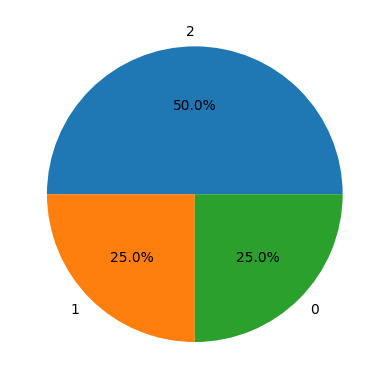

In [ ]:
plt.pie(df['labels'].value_counts().values,
        labels = df['labels'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

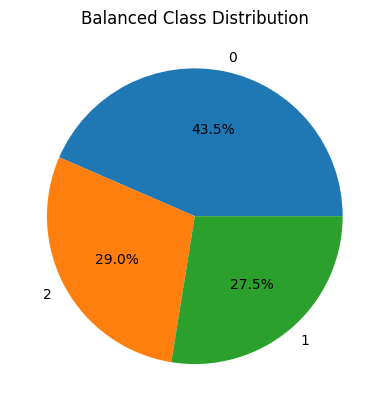

In [ ]:
class_0 = df[df['labels'] == 0]  # Hate Speech
class_1 = df[df['labels'] == 1].sample(n=3500, random_state=42, replace=True)  # Offensive Language
class_2 = df[df['labels'] == 2]  # Neutral

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

# Visualize the balanced distribution
plt.pie(balanced_df['labels'].value_counts().values,
        labels=balanced_df['labels'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Balanced Class Distribution")
plt.show()

In [ ]:
df['tweet'] = df['tweet'].str.lower()

punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,tweet,labels
0,tangkap ahok rakyatbersamafpi indonesia akan h...,2
1,status dukung gerakan matikan lilin untuk ahok...,2
2,aki amien rais bilang prabowo dengan bung karn...,2
3,belajar dari negara tetanga vietnam terbukti k...,2
4,sih cebong sudah kebanyakan makan kotoran joko...,2


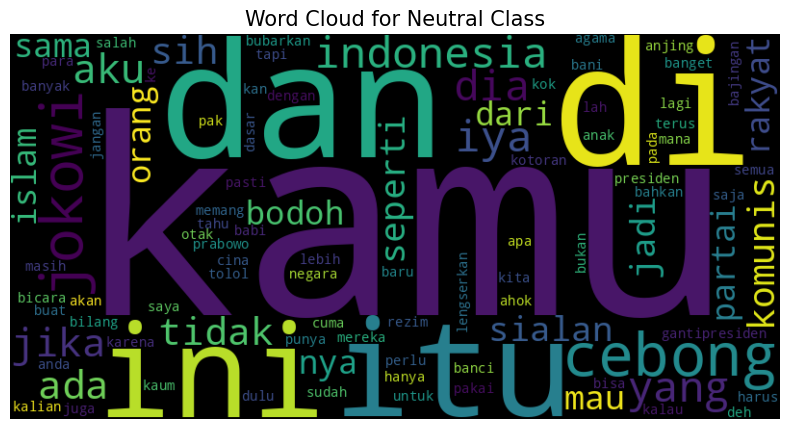

In [ ]:
def plot_word_cloud(data, typ):
    corpus = " ".join(data['tweet'])
    wc = WordCloud(max_words=100, width=800, height=400, collocations=False).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {typ} Class", fontsize=15)
    plt.show()

plot_word_cloud(balanced_df[balanced_df['labels'] == 2], typ="Neutral")

In [ ]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

balanced_df['tweet'] = balanced_df['tweet'].apply(preprocess_text)

In [ ]:
features = balanced_df['tweet']
target = balanced_df['labels']
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# One-hot encode the labels
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

# Tokenization
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

max_words = 10000
max_len = 100

model = keras.models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape=(None, max_len))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,755 (1.32 MB)

 Trainable params: 345,731 (1.32 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

In [ ]:
history = model.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es, lr])

Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.7757 - loss: 3.5209 - val_accuracy: 0.8100 - val_loss: 0.7288 - learning_rate: 0.0010
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.9674 - loss: 0.1867 - val_accuracy: 0.9630 - val_loss: 0.1883 - learning_rate: 0.0010
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - accuracy: 0.9861 - loss: 0.1059 - val_accuracy: 0.9681 - val_loss: 0.1445 - learning_rate: 0.0010
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.9892 - loss: 0.0868 - val_accuracy: 0.9595 - val_loss: 0.1901 - learning_rate: 0.0010
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9915 - loss: 0.0763 - val_accuracy: 0.9670 - val_loss: 0.1913 - learning_rate: 0.0010
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9956 - loss: 0.0505 - val_accuracy: 0.9701 - val_loss: 0.1395 - learning_rate: 5.0000e-04
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - accuracy: 0.9975

<Axes: title={'center': 'Loss'}>

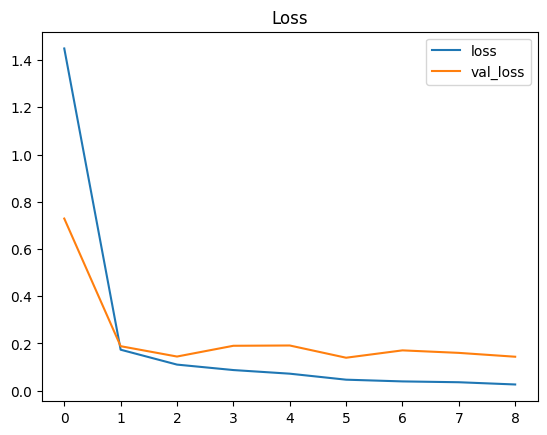

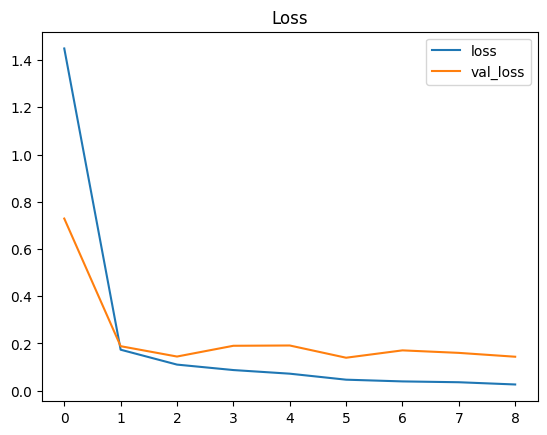

In [ ]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot(title="Loss")
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot(title="Loss")

In [ ]:
test_loss, test_acc = model.evaluate(X_val_padded, Y_val)
print(f"Validation Accuracy: {test_acc:.2f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9691 - loss: 0.1486
Validation Accuracy: 0.97
